# My First Hotdog detector

Last time, we managed to finally get the images we need to build a [sweet sweet hotdog/nohotdog classifier] using [Deep Learning]. This time, we are finally going to play around with Convolutional Neural Networks (CNNs)! But wait, what are those???

TODO: some quick instructions or reference for installing Keras with GPU.

TODO: convolutional neural networks

[sweet sweet hotdog/nohotdog classifier]: https://www.youtube.com/watch?v=ACmydtFDTGs
[Deep Learning]: 

In [1]:
import keras
from keras import backend as K

Using TensorFlow backend.


We are going to learn some hotdogs! The basic tool we are going to use is a Convolutional Neural Network (CNN). CNNs have revolutionized computer vision in the last few years

In [2]:
from keras.layers import Conv2D, MaxPooling2D, InputLayer, Flatten, Dense

my_first_cnn = keras.Sequential()
my_first_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)))
my_first_cnn.add(MaxPooling2D((2,2)))
my_first_cnn.add(Conv2D(32, (3, 3), activation='relu'))
my_first_cnn.add(MaxPooling2D((2,2)))
my_first_cnn.add(Flatten())
my_first_cnn.add(Dense(64, activation='relu'))
my_first_cnn.add(Dense(1, activation='sigmoid'))

my_first_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 118, 118, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1605696   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total para

In [3]:
from keras.preprocessing.image import ImageDataGenerator
import os

base_dir = 'databackup//'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(rescale=1 / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1 / 255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(120,120),
                                                    batch_size=100,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(120,120),
                                                        batch_size=100,
                                                        class_mode='binary')

Found 4765 images belonging to 2 classes.
Found 888 images belonging to 2 classes.


In [4]:
from keras.optimizers import Adam

my_first_cnn.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['acc'])

history = my_first_cnn.fit_generator(train_generator,
                                     steps_per_epoch=30,
                                     epochs=10,
                                     validation_data=validation_generator,
                                     validation_steps=10)

Epoch 1/10
30/30 [==============================] - 108s 4s/step - loss: 0.4251 - acc: 0.8763 - val_loss: 0.3390 - val_acc: 0.8725
Epoch 2/10
30/30 [==============================] - 20s 653ms/step - loss: 0.3067 - acc: 0.8720 - val_loss: 0.3026 - val_acc: 0.8735
Epoch 3/10
30/30 [==============================] - 20s 665ms/step - loss: 0.2803 - acc: 0.8750 - val_loss: 0.2624 - val_acc: 0.8634
Epoch 4/10
30/30 [==============================] - 20s 667ms/step - loss: 0.2547 - acc: 0.8793 - val_loss: 0.2436 - val_acc: 0.8745
Epoch 5/10
30/30 [==============================] - 20s 651ms/step - loss: 0.2523 - acc: 0.8693 - val_loss: 0.2355 - val_acc: 0.8715
Epoch 6/10
30/30 [==============================] - 20s 674ms/step - loss: 0.2492 - acc: 0.8763 - val_loss: 0.2422 - val_acc: 0.8654
Epoch 7/10
30/30 [==============================] - 20s 668ms/step - loss: 0.2331 - acc: 0.8832 - val_loss: 0.2284 - val_acc: 0.8988
Epoch 8/10
30/30 [==============================] - 20s 672ms/step - lo

Magic! In only a few minutes, we are getting a classifier with close to 90% accuracy!

Now that I come to think of it, we have XXXX hotdog images and XXXX nohotdog images, so a lazy classifier that assigns everything a 'nothotdog' label would get around 87% accuracy. Let's check if that's the case.

### Confusion matrix, precision and recall

The confusion matrix is a basic conceptual tool in binary classification. It's just a matrix such that rows represent true classes and columns represent predicted classes. 

Keras has assigned the label 0 to our hotdog class, which we consider positive, and 1 to our nothotdog class, which we consider negative. Therefore, in our binary classification setting we will have true positives top left, true negatives bottom right, false positives bottom left, and false negatives top right.

Therefore, precision will be

$$ precision = \frac{true\ positives}{predicted\ positives} = \frac{C_{0,0}}{C_{0,0} + C_{1,0}} $$

and recall will be:

$$ recall = \frac{true\ positives}{total\ positives} = \frac{C_{0,0}}{C_{0,0} + C_{0,1}}$$


In [5]:
validation_generator_noshuffle = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(120,120),
                                                        batch_size=100,
                                                        shuffle=False,                                                            
                                                        class_mode='binary')

predictions = my_first_cnn.predict_generator(validation_generator_noshuffle)

predictions.shape

Found 888 images belonging to 2 classes.


(888, 1)

0.75 0.210526315789


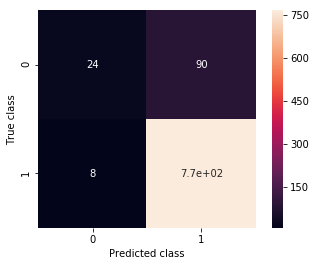

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

C = confusion_matrix(validation_generator_noshuffle.classes, predictions > .5)
ax = sns.heatmap(C, annot=True, square=True)
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')

precision = C[0,0] / (C[0,0] + C[1,0])
recall = C[0][0] / (C[0,0] + C[0,1])

print(precision, recall)

Oh. Right. That means that only XXX% of our predicted hotdogs are such, and that we only detect around XXX% of all the hotdogs in the dataset.

That illustrates a very important idea to keep in mind: choose the right metrics! Specially in unbalanced datasets, accuracy can be really really important. We are fitting on binary cross entropy, but it will naturally focus on getting right the most common class. For that, fit_generator provides a `class_weight` parameter that allows us to artificially give more importance to underrepresented or specially important classes. Let's try it:

In [7]:
from keras.optimizers import Adam

my_first_cnn.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['acc'])

history = my_first_cnn.fit_generator(train_generator,
                                     class_weight = {0: 7, 1: 1},
                                     steps_per_epoch=30,
                                     epochs=10,
                                     validation_data=validation_generator,
                                     validation_steps=10)

Epoch 1/10
30/30 [==============================] - 23s 780ms/step - loss: 1.0079 - acc: 0.8025 - val_loss: 0.3556 - val_acc: 0.8239
Epoch 2/10
30/30 [==============================] - 20s 679ms/step - loss: 0.9124 - acc: 0.8320 - val_loss: 0.3640 - val_acc: 0.7864
Epoch 3/10
30/30 [==============================] - 20s 657ms/step - loss: 0.8670 - acc: 0.8224 - val_loss: 0.3762 - val_acc: 0.7591
Epoch 4/10
30/30 [==============================] - 21s 684ms/step - loss: 0.9297 - acc: 0.7937 - val_loss: 0.3091 - val_acc: 0.8289
Epoch 5/10
30/30 [==============================] - 20s 670ms/step - loss: 0.8074 - acc: 0.8454 - val_loss: 0.3684 - val_acc: 0.7551
Epoch 6/10
30/30 [==============================] - 20s 653ms/step - loss: 0.8741 - acc: 0.8010 - val_loss: 0.3238 - val_acc: 0.8087
Epoch 7/10
30/30 [==============================] - 20s 679ms/step - loss: 0.8670 - acc: 0.8235 - val_loss: 0.3067 - val_acc: 0.8117
Epoch 8/10
30/30 [==============================] - 20s 654ms/step - 

This time the confusion matrix is this one:

0.332278481013 0.921052631579


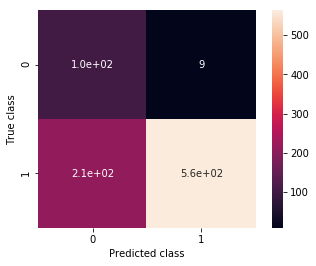

In [8]:
predictions = my_first_cnn.predict_generator(validation_generator_noshuffle)

C = confusion_matrix(validation_generator_noshuffle.classes, predictions > .5)
ax = sns.heatmap(C, annot=True, square=True)
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')

precision = C[0,0] / (C[0,0] + C[1,0])
recall = C[0][0] / (C[0,0] + C[0,1])

print(precision, recall)

Much better! This won't blow Jian-Yang away, but it's a a lot better, despite having worse accuracy. Consider that before this morning, you had no idea how to code a program to have some perception of the real world. Now you can!

Anyway, we have a classifier. It's not great, but I'm sure it can get better. Let's train it a bit more, shall we?

In [9]:
from keras.optimizers import Adam

my_first_cnn.compile(loss='binary_crossentropy',
                     optimizer=Adam(lr=1e-3),
                     metrics=['acc'])

history_pt2 = my_first_cnn.fit_generator(train_generator,
                                         steps_per_epoch=30,
                                         epochs=20,
                                         validation_data=validation_generator,
                                         validation_steps=10,
                                         verbose=1)

Epoch 1/20
30/30 [==============================] - 23s 770ms/step - loss: 0.2505 - acc: 0.8816 - val_loss: 0.2233 - val_acc: 0.9059
Epoch 2/20
30/30 [==============================] - 20s 679ms/step - loss: 0.2377 - acc: 0.8920 - val_loss: 0.2084 - val_acc: 0.9008
Epoch 3/20
30/30 [==============================] - 20s 668ms/step - loss: 0.2307 - acc: 0.8944 - val_loss: 0.2311 - val_acc: 0.9119
Epoch 4/20
30/30 [==============================] - 20s 680ms/step - loss: 0.2129 - acc: 0.9103 - val_loss: 0.2042 - val_acc: 0.9119
Epoch 5/20
30/30 [==============================] - 20s 663ms/step - loss: 0.2183 - acc: 0.9024 - val_loss: 0.2119 - val_acc: 0.9069
Epoch 6/20
30/30 [==============================] - 20s 652ms/step - loss: 0.2209 - acc: 0.9006 - val_loss: 0.2116 - val_acc: 0.9028
Epoch 7/20
30/30 [==============================] - 20s 677ms/step - loss: 0.2253 - acc: 0.9021 - val_loss: 0.2058 - val_acc: 0.9119
Epoch 8/20
30/30 [==============================] - 20s 671ms/step - 

What's happening here? We are seeing a typical case of overfitting. Our training loss is improving really fast, but at the same time the validation loss increases in each epoc. The network is learning the specific details of the training set, which don't generalize all that well to the samples in the validation set. 

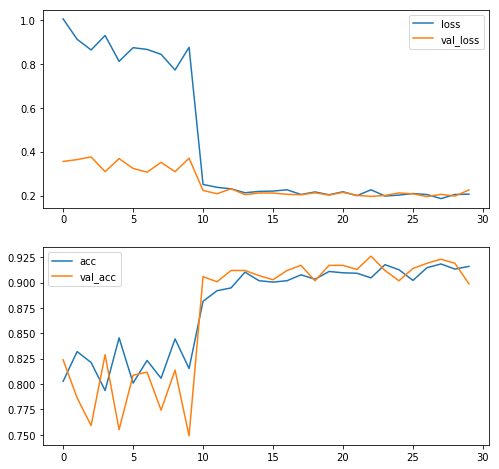

In [10]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(2,1)

f.set_size_inches(8,8)

nb_epochs = len(history.epoch)
concatenated = history.epoch + [nb_epochs + epoch_number for epoch_number in history_pt2.epoch]

axes[0].plot(concatenated, history.history['loss'] + history_pt2.history['loss'], label='loss')
axes[0].plot(concatenated, history.history['val_loss'] + history_pt2.history['val_loss'], label='val_loss')
axes[0].legend()

axes[1].plot(concatenated, history.history['acc'] + history_pt2.history['acc'], label='acc')
axes[1].plot(concatenated, history.history['val_acc'] + history_pt2.history['val_acc'], label='val_acc')
axes[1].legend()

0.72131147541 0.385964912281


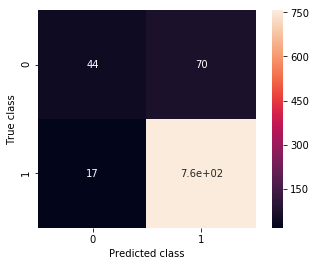

In [11]:
predictions = my_first_cnn.predict_generator(validation_generator_noshuffle)

C = confusion_matrix(validation_generator_noshuffle.classes, predictions > .5)
ax = sns.heatmap(C, annot=True, square=True)
ax.set_ylabel('True class')
ax.set_xlabel('Predicted class')

precision = C[0,0] / (C[0,0] + C[1,0])
recall = C[0][0] / (C[0,0] + C[0,1])

print(precision, recall)

This is the tightrope act that we must make all the time when practising Machine Learning: the [bias-variance tradeoff]. In short, that refers to the trade-off between flexibility and generality of the models. A sufficiently flexible (read: complicated) model will always be able to learn non-relevant details of the input dataset (to overfit), and Neural Networks are nothing if not complicated: notice above where we built our simple CNN: it has over $10^6$ parameters! That's over a million knobs to tweak.

Overfitting means we have high variance: different samples will lead to very different estimations of the parameters. That will manifest as higher validation loss than training loss, as we see here from about epoch 8.

The solutions are simple but varied, and we need to keep many of them in our bag of tools for different occasions. Some are very general and some are pretty specific, but all of them fall under the heading of [regularization]. [This] is probably the best explanation of that that I've heard. In short, we want to penalize somehow the complexity of our models. That will in turn result in better generality.

In our specific example, image recognition, there's one very intuitive way to make our model recognize more varied images of hotdogs: to feed it more varied images of hotdogs. Since we already collected as many as we could, what we can do is to _generate_ more varied images of hotdogs.

[bias-variance tradeoff]: https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff
[regularization]: https://en.wikipedia.org/wiki/Regularization_(mathematics)#Generalization
[This]: https://www.coursera.org/lecture/machine-learning/regularization-and-bias-variance-4VDlf

### Further Reading

https://www.pyimagesearch.com/2018/07/02/an-interview-with-francois-chollet/ author of DL with Python, writer of Keras, favors practice over theory.

